In [1]:
from IPython.core.display import display, HTML
display(HTML('<style>.container { width: 98% !important }</style>'))

In [2]:
from utilities import *

In [3]:
import joblib
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
from sklearn.preprocessing import normalize
import seaborn as sns

sns.set()

In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

## Import Data

In [5]:
pin = read_pin('../Data/pin.csv')
test_pin = read_pin('../Data/testPin.csv')
ble = read_ble('../Data/ble.csv')

In [6]:
data_1 = read_data('../Data/rssi5.csv')
data_2 = read_data('../Data/rssi_2.csv')

All beacons: ['0117C55D14E4']
Selecting all
All beacons: ['0117C55D14E4']
Selecting all


In [7]:
test_1 = read_data('../Data/testRssi.csv')
test_2 = read_data('../Data/testRssi_2.csv')

All beacons: ['0117C55D14E4']
Selecting all
All beacons: ['0117C55D14E4']
Selecting all


In [8]:
data = pd.concat([data_1, data_2], axis=0)
test = pd.concat([test_1, test_2], axis=0)

In [9]:
test.shape

(27229, 19)

## Train Validation Split

In [10]:
train, validation = train_validation_split(data)

In [11]:
print(train.shape)
print(validation.shape)

(102033, 19)
(11337, 19)


In [12]:
def linear_impute(data):
    for s in scanners:
        dx = data['X'] - ble[s]['X']
        dy = data['Y'] - ble[s]['Y']
        d = np.sqrt(np.square(dy) + np.square(dx))
        reg = joblib.load('../Models/linear_distance_models_2/{}.joblib'.format(s))
        ss = pd.Series(reg.predict(d.values.reshape((-1, 1))))
        data[s].fillna(ss, inplace=True)

def impute(data):
    rolling_win = 10

    data = data.sort_values("time")
    data_grouped = data.set_index('time').groupby([pd.Grouper('location'), pd.Grouper(freq='100ms')]).mean().reset_index()
    data_rolled = data_grouped.groupby("location").rolling(rolling_win, min_periods=1).mean().reset_index()
    data_imputed = data_rolled.set_index("location").groupby("location").ffill().reset_index()
    data_imputed["X"] = data_imputed["location"].apply(lambda x: pin[x]["X"] if x[0] == 'V' else test_pin[x]["X"])
    data_imputed["Y"] = data_imputed["location"].apply(lambda x: pin[x]["Y"] if x[0] == 'V' else test_pin[x]["Y"])
    linear_impute(data_imputed)
    return data_imputed

In [13]:
train_imputed = impute(train)
validation_imputed = impute(validation)
test_imputed = impute(test)

In [14]:
train_imputed[scanners] = normalize(train_imputed[scanners] + 100)
validation_imputed[scanners] = normalize(validation_imputed[scanners] + 100)
test_imputed[scanners] = normalize(test_imputed[scanners] + 100)

In [15]:
train_imputed

,location,level_1,C400A2E19293,CD4533FFC0E1,D2B6503554D7,DB8B36A69C56,DD697EA75B68,DF231643E227,E13B805C6CB0,E43355CA8B96,...,E8FD0B453DC4,E96AF2C858BA,EC72840D9AD3,F1307ECB3B90,F1EDAF28E08A,F69A86823B96,FB2EE01C18CE,FDAE5980F28C,X,Y
0,V1_10,0,0.269998,0.232650,0.210630,0.352425,0.280771,0.192865,0.184881,0.284048,...,0.206622,0.112983,0.306226,0.355619,0.254194,0.218076,0.043688,0.277252,11.17660,5.29753
1,V1_10,1,0.323051,0.228668,0.207025,0.346393,0.275966,0.189564,0.181716,0.279187,...,0.203085,0.111049,0.300985,0.349533,0.249844,0.214344,0.042941,0.272507,11.17660,5.29753
2,V1_10,2,0.323185,0.228763,0.207111,0.346537,0.276080,0.189643,0.181792,0.279303,...,0.203170,0.111095,0.301110,0.348434,0.249948,0.214433,0.042959,0.272688,11.17660,5.29753
3,V1_10,3,0.321696,0.227709,0.206156,0.344940,0.274808,0.188769,0.180954,0.261378,...,0.226193,0.110583,0.299722,0.346829,0.248796,0.231219,0.042761,0.271431,11.17660,5.29753
4,V1_10,4,0.321373,0.232320,0.210331,0.351925,0.280373,0.194875,0.138464,0.241030,...,0.233337,0.112822,0.266671,0.353852,0.253834,0.235901,0.043627,0.297441,11.17660,5.29753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48776,V1_9,48776,0.272732,0.139149,0.211506,0.322826,0.166979,0.100187,0.222638,0.411881,...,0.178111,0.100187,0.300562,0.267166,0.317260,0.233770,0.066792,0.367353,8.17867,5.28213
48777,V1_9,48777,0.271145,0.138339,0.210276,0.320947,0.166007,0.099604,0.221343,0.409484,...,0.199208,0.099604,0.298813,0.265611,0.354148,0.177074,0.066403,0.365215,8.17867,5.28213
48778,V1_9,48778,0.275359,0.112391,0.213544,0.275359,0.168587,0.101152,0.224783,0.415848,...,0.202305,0.101152,0.303457,0.280979,0.359653,0.179826,0.067435,0.370892,8.17867,5.28213
48779,V1_9,48779,0.275729,0.112543,0.213831,0.247594,0.168814,0.123797,0.225085,0.416408,...,0.202577,0.101288,0.315119,0.281357,0.360136,0.180068,0.067526,0.371391,8.17867,5.28213


## Model Training

In [16]:
X_train, y_train = train_imputed[scanners].values, train_imputed[["X", "Y"]].values
X_validation, y_validation = validation_imputed[scanners].values, validation_imputed[["X", "Y"]].values
X_test, y_test = test_imputed[scanners].values, test_imputed[["X", "Y"]].values

In [17]:
optimizer = tf.keras.optimizers.RMSprop(0.0001)
loss = "mse"
metrics = ["mae", "mse"]
batch_size = 32
epochs = 10000

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=50, monitor='val_loss')
]

inputs = tf.keras.Input(shape=(17,))

stats = tf.keras.layers.Dense(8, activation='relu')(inputs)

features = tf.keras.layers.Concatenate(axis=1)([stats, inputs])

x = tf.keras.layers.Dense(128, activation='relu')(features)
x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.Dense(1)(x)

y = tf.keras.layers.Dense(128, activation='relu')(features)
y = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(y)
y = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(y)
y = tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(y)
y = tf.keras.layers.Dense(1)(y)

outputs = tf.keras.layers.Concatenate(axis=1)([x, y])

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 17)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 8)            144         input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 25)           0           dense[0][0]                      
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          3328        concatenate[0][0]            

In [19]:
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=epochs, batch_size=batch_size, callbacks=callbacks)

Train on 48781 samples, validate on 10311 samples
Epoch 1/10000
48781/48781 [==============================] - 5s 111us/sample - loss: 85.8271 - mae: 6.4831 - mse: 85.6449 - val_loss: 11.5212 - val_mae: 2.7063 - val_mse: 11.3962
Epoch 2/10000
48781/48781 [==============================] - 4s 74us/sample - loss: 3.9749 - mae: 1.5095 - mse: 3.8452 - val_loss: 2.5714 - val_mae: 1.2344 - val_mse: 2.4403
Epoch 3/10000
48781/48781 [==============================] - 3s 53us/sample - loss: 2.3859 - mae: 1.1594 - mse: 2.2532 - val_loss: 2.4376 - val_mae: 1.1687 - val_mse: 2.3030
Epoch 4/10000
48781/48781 [==============================] - 2s 44us/sample - loss: 2.1956 - mae: 1.0927 - mse: 2.0587 - val_loss: 2.2974 - val_mae: 1.1215 - val_mse: 2.1579
Epoch 5/10000
48781/48781 [==============================] - 2s 45us/sample - loss: 2.0639 - mae: 1.0442 - mse: 1.9215 - val_loss: 2.2102 - val_mae: 1.0869 - val_mse: 2.0648
Epoch 6/10000
48781/48781 [==============================] - 2s 38us/sample

48781/48781 [==============================] - 2s 35us/sample - loss: 0.5188 - mae: 0.3982 - mse: 0.3665 - val_loss: 0.9624 - val_mae: 0.6111 - val_mse: 0.8106
Epoch 48/10000
48781/48781 [==============================] - 2s 35us/sample - loss: 0.5105 - mae: 0.3944 - mse: 0.3592 - val_loss: 0.8156 - val_mae: 0.5262 - val_mse: 0.6648
Epoch 49/10000
48781/48781 [==============================] - 2s 36us/sample - loss: 0.5037 - mae: 0.3904 - mse: 0.3535 - val_loss: 0.8382 - val_mae: 0.5393 - val_mse: 0.6886
Epoch 50/10000
48781/48781 [==============================] - 2s 36us/sample - loss: 0.4975 - mae: 0.3871 - mse: 0.3483 - val_loss: 0.7981 - val_mae: 0.5169 - val_mse: 0.6495
Epoch 51/10000
48781/48781 [==============================] - 2s 36us/sample - loss: 0.4899 - mae: 0.3827 - mse: 0.3417 - val_loss: 0.8118 - val_mae: 0.5232 - val_mse: 0.6642
Epoch 52/10000
48781/48781 [==============================] - 2s 36us/sample - loss: 0.4843 - mae: 0.3797 - mse: 0.3371 - val_loss: 0.8093 -

Epoch 94/10000
48781/48781 [==============================] - 2s 36us/sample - loss: 0.3338 - mae: 0.2900 - mse: 0.2136 - val_loss: 0.7579 - val_mae: 0.5162 - val_mse: 0.6380
Epoch 95/10000
48781/48781 [==============================] - 2s 36us/sample - loss: 0.3325 - mae: 0.2894 - mse: 0.2130 - val_loss: 0.6461 - val_mae: 0.4317 - val_mse: 0.5267
Epoch 96/10000
48781/48781 [==============================] - 2s 36us/sample - loss: 0.3294 - mae: 0.2877 - mse: 0.2103 - val_loss: 0.6214 - val_mae: 0.4305 - val_mse: 0.5025
Epoch 97/10000
48781/48781 [==============================] - 2s 36us/sample - loss: 0.3283 - mae: 0.2866 - mse: 0.2097 - val_loss: 0.6135 - val_mae: 0.4180 - val_mse: 0.4951
Epoch 98/10000
48781/48781 [==============================] - 2s 36us/sample - loss: 0.3253 - mae: 0.2852 - mse: 0.2072 - val_loss: 0.6112 - val_mae: 0.4146 - val_mse: 0.4934
Epoch 99/10000
48781/48781 [==============================] - 2s 36us/sample - loss: 0.3237 - mae: 0.2840 - mse: 0.2061 - val

48781/48781 [==============================] - 2s 36us/sample - loss: 0.2697 - mae: 0.2492 - mse: 0.1680 - val_loss: 0.5345 - val_mae: 0.3746 - val_mse: 0.4330
Epoch 141/10000
48781/48781 [==============================] - 2s 36us/sample - loss: 0.2691 - mae: 0.2489 - mse: 0.1677 - val_loss: 0.5694 - val_mae: 0.3962 - val_mse: 0.4682
Epoch 142/10000
48781/48781 [==============================] - 2s 36us/sample - loss: 0.2678 - mae: 0.2483 - mse: 0.1667 - val_loss: 0.7723 - val_mae: 0.5241 - val_mse: 0.6713
Epoch 143/10000
48781/48781 [==============================] - 2s 36us/sample - loss: 0.2668 - mae: 0.2474 - mse: 0.1660 - val_loss: 0.6689 - val_mae: 0.4575 - val_mse: 0.5683
Epoch 144/10000
48781/48781 [==============================] - 2s 36us/sample - loss: 0.2661 - mae: 0.2470 - mse: 0.1656 - val_loss: 0.5762 - val_mae: 0.3917 - val_mse: 0.4758
Epoch 145/10000
48781/48781 [==============================] - 2s 36us/sample - loss: 0.2646 - mae: 0.2460 - mse: 0.1644 - val_loss: 0.6

48781/48781 [==============================] - 2s 35us/sample - loss: 0.2317 - mae: 0.2220 - mse: 0.1407 - val_loss: 0.4836 - val_mae: 0.3428 - val_mse: 0.3927
Epoch 187/10000
48781/48781 [==============================] - 2s 35us/sample - loss: 0.2301 - mae: 0.2217 - mse: 0.1393 - val_loss: 0.5293 - val_mae: 0.3677 - val_mse: 0.4385
Epoch 188/10000
48781/48781 [==============================] - 2s 35us/sample - loss: 0.2294 - mae: 0.2207 - mse: 0.1389 - val_loss: 0.5170 - val_mae: 0.3626 - val_mse: 0.4265
Epoch 189/10000
48781/48781 [==============================] - 2s 35us/sample - loss: 0.2291 - mae: 0.2203 - mse: 0.1387 - val_loss: 0.5098 - val_mae: 0.3516 - val_mse: 0.4195
Epoch 190/10000
48781/48781 [==============================] - 2s 35us/sample - loss: 0.2275 - mae: 0.2198 - mse: 0.1372 - val_loss: 0.5445 - val_mae: 0.3782 - val_mse: 0.4544
Epoch 191/10000
48781/48781 [==============================] - 2s 35us/sample - loss: 0.2274 - mae: 0.2193 - mse: 0.1373 - val_loss: 0.5

48781/48781 [==============================] - 2s 36us/sample - loss: 0.2014 - mae: 0.1999 - mse: 0.1179 - val_loss: 0.5264 - val_mae: 0.3860 - val_mse: 0.4428
Epoch 233/10000
48781/48781 [==============================] - 2s 36us/sample - loss: 0.2000 - mae: 0.1985 - mse: 0.1167 - val_loss: 0.4621 - val_mae: 0.3256 - val_mse: 0.3789
Epoch 234/10000
48781/48781 [==============================] - 2s 36us/sample - loss: 0.1992 - mae: 0.1981 - mse: 0.1160 - val_loss: 0.4588 - val_mae: 0.3281 - val_mse: 0.3758
Epoch 235/10000
48781/48781 [==============================] - 2s 36us/sample - loss: 0.1990 - mae: 0.1983 - mse: 0.1159 - val_loss: 0.4944 - val_mae: 0.3584 - val_mse: 0.4115
Epoch 236/10000
48781/48781 [==============================] - 2s 36us/sample - loss: 0.1990 - mae: 0.1980 - mse: 0.1161 - val_loss: 0.5930 - val_mae: 0.4288 - val_mse: 0.5102
Epoch 237/10000
48781/48781 [==============================] - 2s 36us/sample - loss: 0.1976 - mae: 0.1972 - mse: 0.1149 - val_loss: 0.4

48781/48781 [==============================] - 2s 36us/sample - loss: 0.1788 - mae: 0.1822 - mse: 0.1017 - val_loss: 0.4548 - val_mae: 0.3305 - val_mse: 0.3779
Epoch 279/10000
48781/48781 [==============================] - 2s 36us/sample - loss: 0.1778 - mae: 0.1817 - mse: 0.1009 - val_loss: 0.4254 - val_mae: 0.2995 - val_mse: 0.3486
Epoch 280/10000
48781/48781 [==============================] - 2s 36us/sample - loss: 0.1779 - mae: 0.1817 - mse: 0.1012 - val_loss: 0.4358 - val_mae: 0.3131 - val_mse: 0.3591
Epoch 281/10000
48781/48781 [==============================] - 2s 36us/sample - loss: 0.1784 - mae: 0.1816 - mse: 0.1018 - val_loss: 0.4264 - val_mae: 0.3016 - val_mse: 0.3498
Epoch 282/10000
48781/48781 [==============================] - 2s 36us/sample - loss: 0.1762 - mae: 0.1803 - mse: 0.0997 - val_loss: 0.4754 - val_mae: 0.3279 - val_mse: 0.3990
Epoch 283/10000
48781/48781 [==============================] - 2s 36us/sample - loss: 0.1768 - mae: 0.1803 - mse: 0.1005 - val_loss: 0.4

48781/48781 [==============================] - 2s 36us/sample - loss: 0.1621 - mae: 0.1691 - mse: 0.0908 - val_loss: 0.4344 - val_mae: 0.3021 - val_mse: 0.3632
Epoch 325/10000
48781/48781 [==============================] - 2s 36us/sample - loss: 0.1620 - mae: 0.1692 - mse: 0.0908 - val_loss: 0.4830 - val_mae: 0.3590 - val_mse: 0.4118
Epoch 326/10000
48781/48781 [==============================] - 2s 36us/sample - loss: 0.1614 - mae: 0.1682 - mse: 0.0903 - val_loss: 0.4567 - val_mae: 0.3153 - val_mse: 0.3856
Epoch 327/10000
48781/48781 [==============================] - 2s 36us/sample - loss: 0.1605 - mae: 0.1677 - mse: 0.0896 - val_loss: 0.6635 - val_mae: 0.4798 - val_mse: 0.5927
Epoch 328/10000
48781/48781 [==============================] - 2s 36us/sample - loss: 0.1604 - mae: 0.1675 - mse: 0.0895 - val_loss: 0.5535 - val_mae: 0.4083 - val_mse: 0.4828
Epoch 329/10000
48781/48781 [==============================] - 2s 36us/sample - loss: 0.1606 - mae: 0.1682 - mse: 0.0899 - val_loss: 0.4

48781/48781 [==============================] - 2s 36us/sample - loss: 0.1486 - mae: 0.1579 - mse: 0.0820 - val_loss: 0.4054 - val_mae: 0.2945 - val_mse: 0.3387
Epoch 371/10000
48781/48781 [==============================] - 2s 36us/sample - loss: 0.1481 - mae: 0.1575 - mse: 0.0815 - val_loss: 0.4076 - val_mae: 0.2806 - val_mse: 0.3410
Epoch 372/10000
48781/48781 [==============================] - 2s 36us/sample - loss: 0.1481 - mae: 0.1576 - mse: 0.0816 - val_loss: 0.3900 - val_mae: 0.2797 - val_mse: 0.3235
Epoch 373/10000
48781/48781 [==============================] - 2s 36us/sample - loss: 0.1482 - mae: 0.1578 - mse: 0.0818 - val_loss: 0.4060 - val_mae: 0.2936 - val_mse: 0.3396
Epoch 374/10000
48781/48781 [==============================] - 2s 36us/sample - loss: 0.1476 - mae: 0.1567 - mse: 0.0813 - val_loss: 0.4105 - val_mae: 0.2835 - val_mse: 0.3443
Epoch 375/10000
48781/48781 [==============================] - 2s 36us/sample - loss: 0.1474 - mae: 0.1569 - mse: 0.0812 - val_loss: 0.4

48781/48781 [==============================] - 2s 36us/sample - loss: 0.1382 - mae: 0.1498 - mse: 0.0754 - val_loss: 0.3873 - val_mae: 0.2662 - val_mse: 0.3245
Epoch 417/10000
48781/48781 [==============================] - 2s 36us/sample - loss: 0.1381 - mae: 0.1491 - mse: 0.0753 - val_loss: 0.4012 - val_mae: 0.2879 - val_mse: 0.3385
Epoch 418/10000
48781/48781 [==============================] - 2s 36us/sample - loss: 0.1372 - mae: 0.1489 - mse: 0.0745 - val_loss: 0.4297 - val_mae: 0.3179 - val_mse: 0.3671
Epoch 419/10000
48781/48781 [==============================] - 2s 36us/sample - loss: 0.1372 - mae: 0.1490 - mse: 0.0746 - val_loss: 0.3945 - val_mae: 0.2850 - val_mse: 0.3319
Epoch 420/10000
48781/48781 [==============================] - 2s 36us/sample - loss: 0.1377 - mae: 0.1492 - mse: 0.0752 - val_loss: 0.3879 - val_mae: 0.2722 - val_mse: 0.3254
Epoch 421/10000
48781/48781 [==============================] - 2s 36us/sample - loss: 0.1372 - mae: 0.1490 - mse: 0.0747 - val_loss: 0.4

48781/48781 [==============================] - 2s 35us/sample - loss: 0.1295 - mae: 0.1434 - mse: 0.0701 - val_loss: 0.3932 - val_mae: 0.2774 - val_mse: 0.3338
Epoch 463/10000
48781/48781 [==============================] - 2s 35us/sample - loss: 0.1291 - mae: 0.1432 - mse: 0.0697 - val_loss: 0.4935 - val_mae: 0.3872 - val_mse: 0.4341
Epoch 464/10000
48781/48781 [==============================] - 2s 35us/sample - loss: 0.1291 - mae: 0.1429 - mse: 0.0698 - val_loss: 0.4446 - val_mae: 0.3124 - val_mse: 0.3853
Epoch 465/10000
48781/48781 [==============================] - 2s 35us/sample - loss: 0.1289 - mae: 0.1432 - mse: 0.0696 - val_loss: 0.4692 - val_mae: 0.3538 - val_mse: 0.4099
Epoch 466/10000
48781/48781 [==============================] - 2s 36us/sample - loss: 0.1291 - mae: 0.1432 - mse: 0.0698 - val_loss: 0.4902 - val_mae: 0.3661 - val_mse: 0.4310
Epoch 467/10000
48781/48781 [==============================] - 2s 35us/sample - loss: 0.1290 - mae: 0.1429 - mse: 0.0698 - val_loss: 0.4

48781/48781 [==============================] - 2s 36us/sample - loss: 0.1223 - mae: 0.1383 - mse: 0.0657 - val_loss: 0.4707 - val_mae: 0.3465 - val_mse: 0.4140
Epoch 509/10000
48781/48781 [==============================] - 2s 36us/sample - loss: 0.1223 - mae: 0.1380 - mse: 0.0658 - val_loss: 0.3707 - val_mae: 0.2636 - val_mse: 0.3141
Epoch 510/10000
48781/48781 [==============================] - 2s 36us/sample - loss: 0.1223 - mae: 0.1383 - mse: 0.0658 - val_loss: 0.3894 - val_mae: 0.2934 - val_mse: 0.3329
Epoch 511/10000
48781/48781 [==============================] - 2s 36us/sample - loss: 0.1222 - mae: 0.1380 - mse: 0.0657 - val_loss: 0.3810 - val_mae: 0.2669 - val_mse: 0.3246
Epoch 512/10000
48781/48781 [==============================] - 2s 36us/sample - loss: 0.1221 - mae: 0.1384 - mse: 0.0657 - val_loss: 0.4400 - val_mae: 0.3058 - val_mse: 0.3836
Epoch 513/10000
48781/48781 [==============================] - 2s 36us/sample - loss: 0.1217 - mae: 0.1380 - mse: 0.0654 - val_loss: 0.4

48781/48781 [==============================] - 2s 36us/sample - loss: 0.1158 - mae: 0.1335 - mse: 0.0618 - val_loss: 0.4243 - val_mae: 0.3106 - val_mse: 0.3703
Epoch 555/10000
48781/48781 [==============================] - 2s 36us/sample - loss: 0.1162 - mae: 0.1342 - mse: 0.0622 - val_loss: 0.3613 - val_mae: 0.2550 - val_mse: 0.3073
Epoch 556/10000
48781/48781 [==============================] - 2s 36us/sample - loss: 0.1162 - mae: 0.1344 - mse: 0.0623 - val_loss: 0.4102 - val_mae: 0.2904 - val_mse: 0.3563
Epoch 557/10000
48781/48781 [==============================] - 2s 36us/sample - loss: 0.1160 - mae: 0.1340 - mse: 0.0621 - val_loss: 0.3596 - val_mae: 0.2676 - val_mse: 0.3058
Epoch 558/10000
48781/48781 [==============================] - 2s 36us/sample - loss: 0.1157 - mae: 0.1340 - mse: 0.0619 - val_loss: 0.3872 - val_mae: 0.2747 - val_mse: 0.3334
Epoch 559/10000
48781/48781 [==============================] - 2s 36us/sample - loss: 0.1157 - mae: 0.1337 - mse: 0.0619 - val_loss: 0.3

48781/48781 [==============================] - 2s 34us/sample - loss: 0.1103 - mae: 0.1302 - mse: 0.0586 - val_loss: 0.3912 - val_mae: 0.2810 - val_mse: 0.3396
Epoch 601/10000
48781/48781 [==============================] - 2s 34us/sample - loss: 0.1102 - mae: 0.1301 - mse: 0.0586 - val_loss: 0.3425 - val_mae: 0.2432 - val_mse: 0.2910
Epoch 602/10000
48781/48781 [==============================] - 2s 34us/sample - loss: 0.1098 - mae: 0.1297 - mse: 0.0583 - val_loss: 0.4051 - val_mae: 0.2991 - val_mse: 0.3535
Epoch 603/10000
48781/48781 [==============================] - 2s 34us/sample - loss: 0.1103 - mae: 0.1303 - mse: 0.0588 - val_loss: 0.3749 - val_mae: 0.2851 - val_mse: 0.3234
Epoch 604/10000
48781/48781 [==============================] - 2s 34us/sample - loss: 0.1100 - mae: 0.1300 - mse: 0.0585 - val_loss: 0.3913 - val_mae: 0.3170 - val_mse: 0.3398
Epoch 605/10000
48781/48781 [==============================] - 2s 34us/sample - loss: 0.1103 - mae: 0.1300 - mse: 0.0589 - val_loss: 0.3

48781/48781 [==============================] - 2s 34us/sample - loss: 0.1059 - mae: 0.1274 - mse: 0.0564 - val_loss: 0.3434 - val_mae: 0.2556 - val_mse: 0.2939
Epoch 647/10000
48781/48781 [==============================] - 2s 34us/sample - loss: 0.1056 - mae: 0.1269 - mse: 0.0561 - val_loss: 0.3545 - val_mae: 0.2529 - val_mse: 0.3051
Epoch 648/10000
48781/48781 [==============================] - 2s 34us/sample - loss: 0.1055 - mae: 0.1273 - mse: 0.0561 - val_loss: 0.3544 - val_mae: 0.2437 - val_mse: 0.3050
Epoch 649/10000
48781/48781 [==============================] - 2s 34us/sample - loss: 0.1055 - mae: 0.1266 - mse: 0.0561 - val_loss: 0.3460 - val_mae: 0.2467 - val_mse: 0.2966
Epoch 650/10000
48781/48781 [==============================] - 2s 34us/sample - loss: 0.1054 - mae: 0.1267 - mse: 0.0561 - val_loss: 0.3774 - val_mae: 0.2848 - val_mse: 0.3281
Epoch 651/10000
48781/48781 [==============================] - 2s 34us/sample - loss: 0.1050 - mae: 0.1266 - mse: 0.0556 - val_loss: 0.3

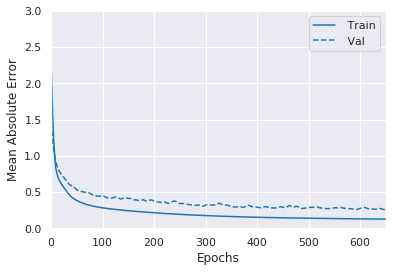

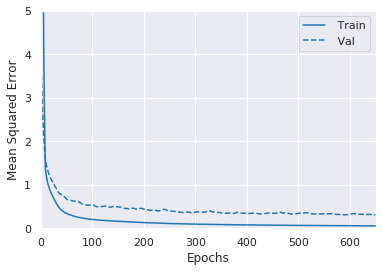

In [20]:
plt.figure()
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({"": history}, metric = "mae")
plt.ylim([0, 3])
plt.ylabel('Mean Absolute Error')

plt.figure()
plotter.plot({"": history}, metric = "mse")
plt.ylim([0, 5])
plt.ylabel('Mean Squared Error')

plt.show()

## Model Validation

In [21]:
def inv_scale(y):
    ret_y = np.copy(y)
    ret_y[:, 0] = ret_y[:, 0] * 33.5
    ret_y[:, 1] = ret_y[:, 1] * 16.8
    return ret_y

def average_distance_error(preds, y_test, scaled=False):
    if scaled:
        preds = inv_scale(preds)
        y_test = inv_scale(y_test)
    return np.mean(np.sqrt(np.sum(np.square(preds - y_test), axis=1)))

In [22]:
def cdf(preds, y_test, test_data=False):
    cpin = test_pin if test_data else pin
    plt.figure(figsize=(5, 5))
    for loc in cpin.keys():
        x_selector = np.isclose(y_test[:, 0], cpin[loc]['X'], atol=0.01)
        y_selector = np.isclose(y_test[:, 1], cpin[loc]['Y'], atol=0.01)
        selector = np.logical_and(x_selector, y_selector)
        selector = selector.reshape(-1)
        Z = np.sqrt(np.sum(np.square(preds[selector] - y_test[selector]), axis=1))
        N = Z.size

        X = np.sort(Z)
        F = np.array(range(N)) / float(N)

        plt.plot(X, F, label=loc)
    plt.title('CDF of Euclidean Distance Error')
    plt.xlabel('Euclidean Distance Error (m)')
    plt.ylabel('Density')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

10311/1 - 0s - loss: 0.2184 - mae: 0.2465 - mse: 0.3115
Validation loss: 0.36080187395245383
Mean absolute error: 0.24654347
Mean squared error: 0.31145978
Average distance error: 0.43607713703946


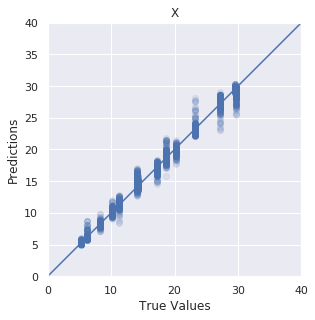

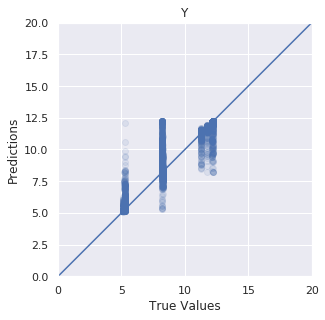

In [23]:
validation_scores = model.evaluate(X_validation, y_validation, verbose=2)
print("Validation loss:", validation_scores[0])
print("Mean absolute error:", validation_scores[1])
print("Mean squared error:", validation_scores[2])

preds = model.predict(X_validation)
print("Average distance error:", average_distance_error(preds, y_validation))

fig = plt.figure(figsize=(10, 20))
lims = [0, 40]
ax1 = fig.add_subplot(121, aspect='equal', title='X', xlim=lims, ylim=lims, xlabel='True Values', ylabel='Predictions')
ax1.scatter(y_validation[:, 0], preds[:, 0], alpha=0.1)
ax1.plot(lims, lims)

fig = plt.figure(figsize=(10, 20))
lims = [0, 20]
ax1 = fig.add_subplot(121, aspect='equal', title='Y', xlim=lims, ylim=lims, xlabel='True Values', ylabel='Predictions')
ax1.scatter(y_validation[:, 1], preds[:, 1], alpha=0.1)
ax1.plot(lims, lims)

plt.show()

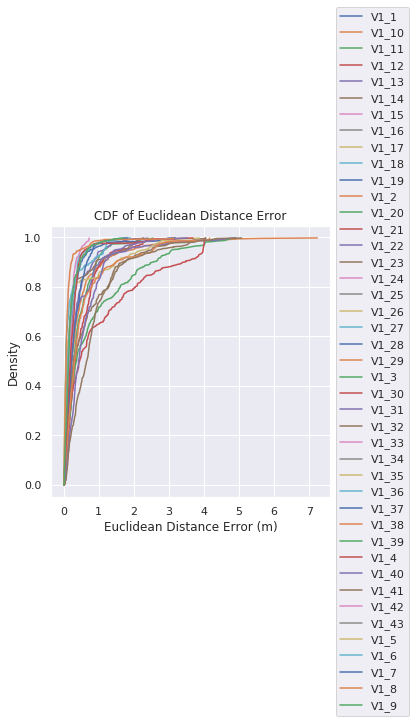

In [24]:
cdf(preds, y_validation)

## Model Testing

11680/1 - 0s - loss: 1.6017 - mae: 1.0730 - mse: 2.0258
Test loss: 2.075115099426818
Mean absolute error: 1.0730447
Mean squared error: 2.0257723
Average distance error: 1.7697421521514458


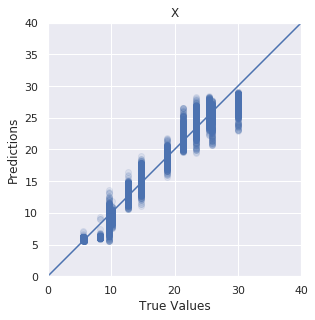

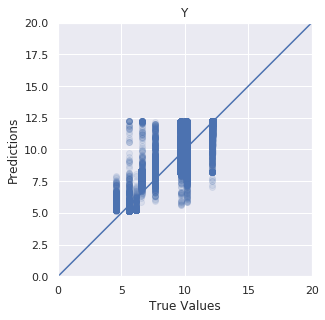

In [25]:
test_scores = model.evaluate(X_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Mean absolute error:", test_scores[1])
print("Mean squared error:", test_scores[2])

preds = model.predict(X_test)
print("Average distance error:", average_distance_error(preds, y_test))

fig = plt.figure(figsize=(10, 20))
lims = [0, 40]
ax1 = fig.add_subplot(121, aspect='equal', title='X', xlim=lims, ylim=lims, xlabel='True Values', ylabel='Predictions')
ax1.scatter(y_test[:, 0], preds[:, 0], alpha=0.1)
ax1.plot(lims, lims)

fig = plt.figure(figsize=(10, 20))
lims = [0, 20]
ax1 = fig.add_subplot(121, aspect='equal', title='Y', xlim=lims, ylim=lims, xlabel='True Values', ylabel='Predictions')

ax1.scatter(y_test[:, 1], preds[:, 1], alpha=0.1)
ax1.plot(lims, lims)

plt.show()

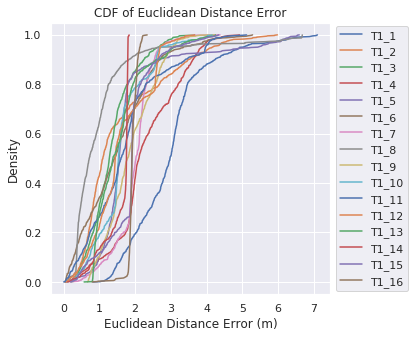

In [26]:
cdf(preds, y_test, test_data=True)

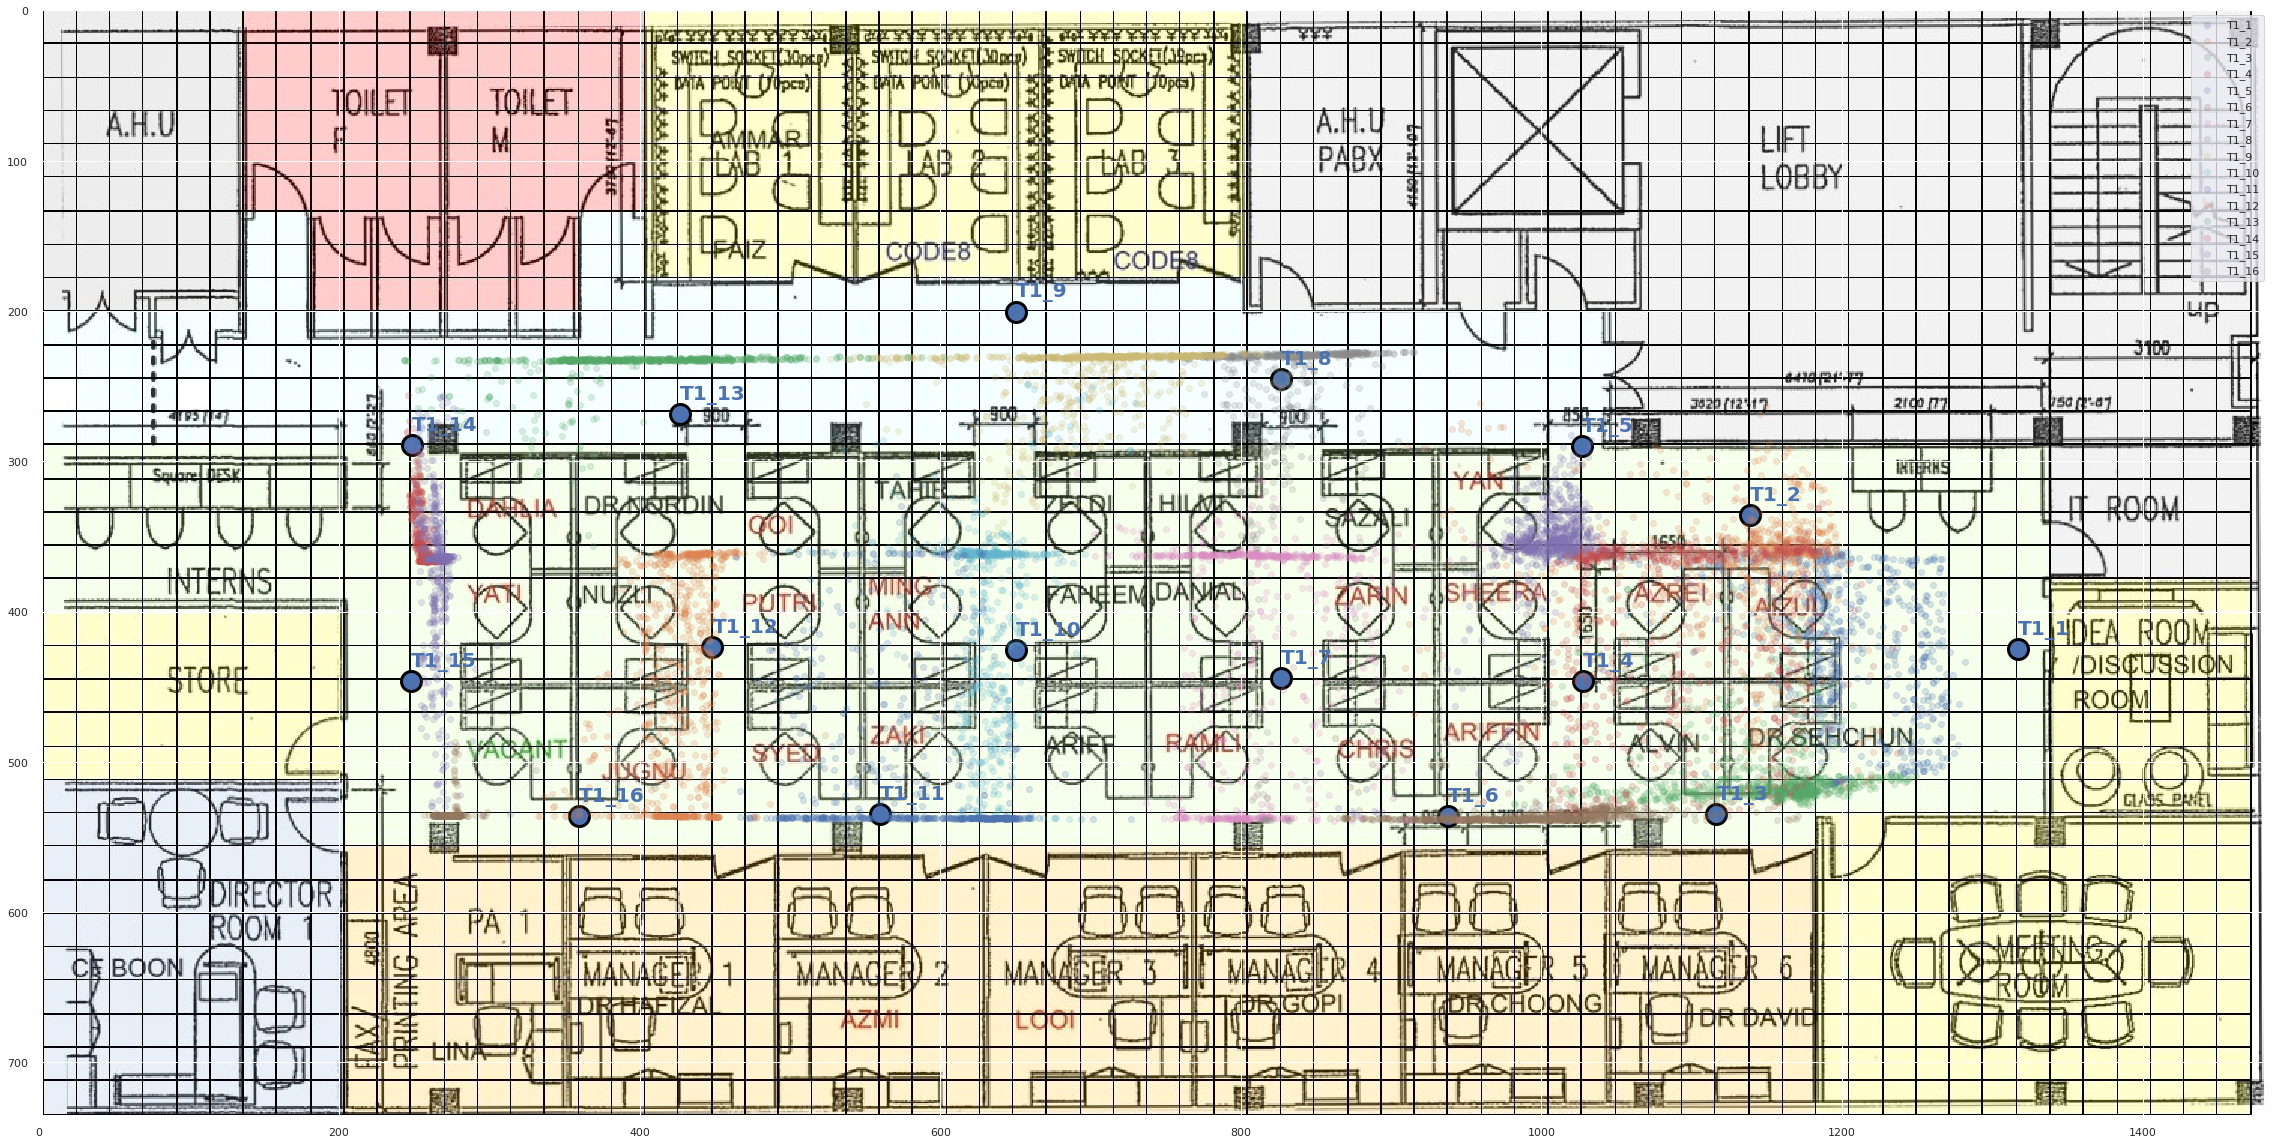

In [27]:
img =  mpimg.imread('../Map/main.png')
fingerprint_color = "r"
testdata_color = "b"
plt.figure(figsize=(40,40))
plt.imshow(img)

labels = ["V1_23", "V1_24", "V1_32", "V1_22", "V1_14", "V1_13", "V1_12", "V1_21", "V1_29", "V1_30", "V1_31", "V1_11", "V1_20", "V1_28", "V1_10", "V1_19", "V1_27", "V1_9", "V1_8", "V1_18", "V1_26"]
x = [27.151600, 29.594400, 29.689400, 23.153700, 23.169100, 20.171700, 17.173201, 18.712299, 18.691700, 23.244200, 27.133301, 14.063600, 14.159800, 14.250300, 11.176600, 10.162500, 10.141900, 8.178670, 5.180690, 6.164600, 6.255650]
y = [8.159480, 8.172020, 11.286000, 8.250140, 5.247920, 5.121330, 5.217130, 8.227330, 12.230300, 12.253700, 11.717700, 5.312350, 8.203950, 12.207500, 5.297530, 8.183420, 12.186400, 5.282130, 5.266730, 8.274090, 12.166400]
x = np.array(x) * 44
y = np.array(y) * 44

testLabels = ["T1_1", "T1_2", "T1_3", "T1_4", "T1_5", "T1_6", "T1_7", "T1_8", "T1_9", "T1_10", "T1_11", "T1_12", "T1_13", "T1_14", "T1_15", "T1_16"]
testX = [29.934250, 25.877805, 25.372470, 23.355726, 23.333564, 21.316819, 18.790348, 18.790348, 14.779021, 14.779021, 12.717952, 10.191480, 9.703916, 5.648265, 5.626103, 8.174736]
testY = [9.659024, 7.630801, 12.155781, 10.139037, 6.593112, 12.177943, 10.094712, 5.573659, 4.554205, 9.673634, 12.155781, 9.629310, 6.105547, 6.570950, 10.139037, 12.177943]
testX = np.array(testX) * 44
testY = np.array(testY) * 44

# plt.scatter(x, y, s=400, c=fingerprint_color, edgecolors="black", linewidths=3)
plt.scatter(testX, testY, s=400, c=testdata_color, edgecolors="black", linewidths=3)

# for i in range(len(labels)):
#     plt.annotate(labels[i], (x[i], y[i] - 10), fontsize=20, color=fingerprint_color, weight='bold')

for j in range(len(testLabels)):
    plt.annotate(testLabels[j], (testX[j], testY[j] - 10), fontsize=20, color=testdata_color, weight='bold')

for i in range(len(testLabels)):
    loc = testLabels[i]
    test_loc = test_imputed[test_imputed['location'] == loc]
    X_loc = test_loc[scanners].values
    locs = model.predict(X_loc) * 44
    plt.scatter(locs[:, 0], locs[:, 1], alpha=0.2, label=testLabels[i])
plt.legend()

In [28]:
model.save("../Models/MLP_FeaturesGeneration.h5")